In [1]:
using DataFrames, FITSIO, FITSTables, JLD2, PyPlot, Statistics
include("air_vacuum.jl")

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/aw/.julia/packages/PyPlot/4wzW1/src/init.jl:192


vac_to_air (generic function with 1 method)

In [2]:
@load "wl_grid.jld2"
Δλ = 7                                                                                                             
li_air = 6707.85
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ
masked_wls = wl_grid[line_mask]
line = air_to_vac(li_air)
;

In [3]:
width = length(masked_wls)
n = length(masked_wls)
M = zeros(2 + n, n)
ϕ(x, μ, σ) = exp(-1/2 * (x-μ)^2/σ^2) / sqrt(2π) / σ #gaussian kernel
M[1, :] = ϕ.(masked_wls, line, width)
M[2, :] .= 1.0
for i in 3:(2+n)
    M[i, i-2] = 1.
end

In [4]:
df = FITS(DataFrame ∘ last, "random_30000_test.classified.fits");

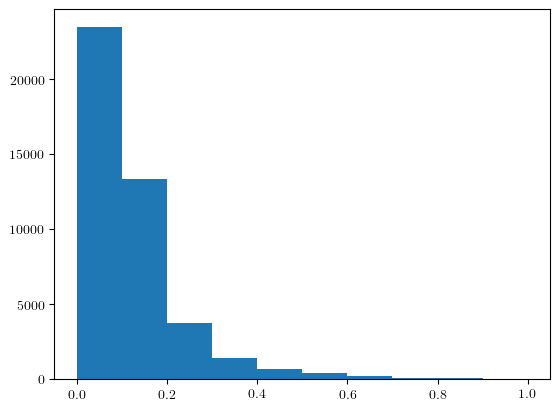

In [5]:
hist(df.EEW, range=[0, 1]);

In [6]:
D = reduce(vcat,transpose.(df.diff))';
P = reduce(vcat,transpose.(df.err))';

In [7]:
l1 = M.^2 * P
l2 = M * (D .* P)
loss = -l2.^2 ./ l1;

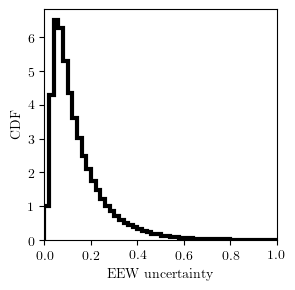

0.9877121014008841

In [86]:
linemodel = M[1, :]
σEEW = 1 ./sqrt.((linemodel.^2)' * P)[:]

figure(figsize=(3, 3))
hist(σEEW, range=[0, 1], bins=50, cumulative=false, histtype="step", lw=3, color="k", density=true);
xlim(0, 1)
xlabel("EEW uncertainty")
ylabel("CDF")

EEW = 0.20
mean(σEEW./EEW .< 3)

In [42]:
linemodel = M[1, :]./sum(M[1, :]');

In [69]:
nullD = randn(size(P)).*(P.^(-1/2))
projDs = (linemodel' * (nullD .* P.^(1/2)))[:];
;

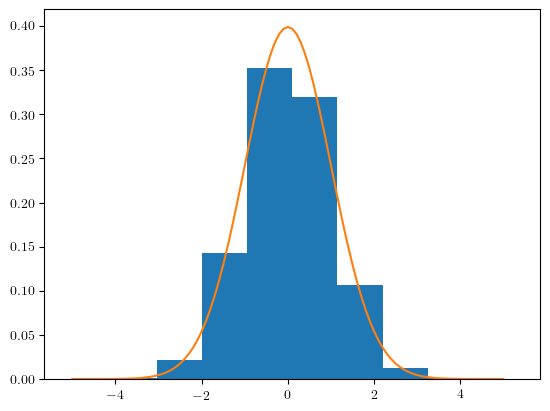

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14186e208>

In [68]:
hist((nullD .* sqrt.(P))[:], density=true)
xs = -5:0.1:5
plot(xs, ϕ.(xs, 0, 1))

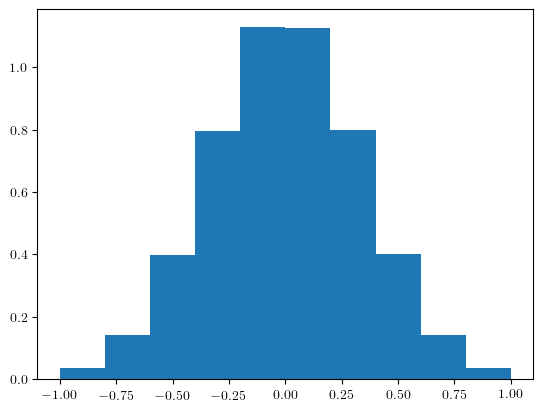

In [73]:
plt.hist(projDs, range=[-1,1], density=true);

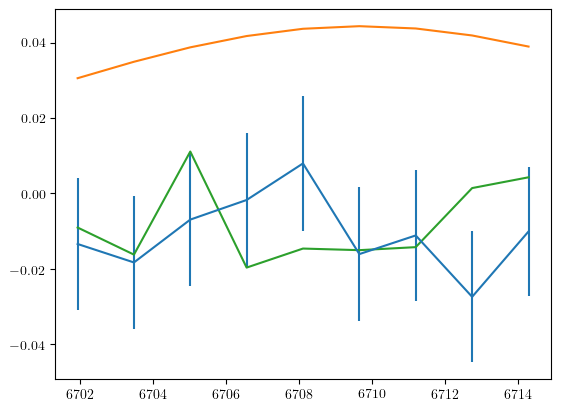

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14f819eb8>

In [46]:
i = rand(1:size(P, 2))
errorbar(masked_wls, nullD[:, i], yerr=P[:, i].^(-1/2))
plot(masked_wls, M[1, :])
plot(masked_wls, D[:, i])

### where are the stars, check that residuals look 3$\sigma$

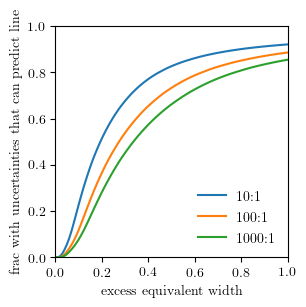

(0.0, 1.0)

In [133]:
figure(figsize=(3, 3))
EEWs = 0:0.01:1.0
plot(EEWs, nflaggable.(1e-1, EEWs), label="10:1")
plot(EEWs, nflaggable.(1e-2, EEWs), label="100:1")
plot(EEWs, nflaggable.(1e-3, EEWs), label="1000:1")
xlabel("excess equivalent width")
ylabel("frac with uncertainties that can predict line")
legend()
xlim(0, 1)
ylim(0, 1)

In [16]:
P.^(-1/2)

9×534591 Array{Float64,2}:
 0.0268811  0.0098362   0.0512259  …  0.032128   0.00162804  0.0201842
 0.027618   0.00974357  0.0524698     0.0314491  0.00162615  0.0200116
 0.0283332  0.00960202  0.0526903     0.0312398  0.00162157  0.0199845
 0.0289527  0.00962753  0.0495463     0.0311409  0.00162393  0.0205419
 0.0286547  0.00964776  0.0518502     0.0320697  0.0016528   0.0217605
 0.0279302  0.00950265  0.0497276  …  0.0343799  0.00168351  0.0223786
 0.0271245  0.00940774  0.0455592     0.0354606  0.00167788  0.0216709
 0.026524   0.00956753  0.0467336     0.0341892  0.00164763  0.0207861
 0.0263324  0.00975452  0.0520021     0.0325097  0.00163124  0.0206318